In [1]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt

In [2]:
"""
TODO:
download next dataframe > 24hrs after original (possibly use time.sleep())
produce timestamps of download times
stocks largest % change overall
stocks largest % change by exchange
industries largest % change
sectors largest % change

"""

'\nTODO:\ndownload next dataframe > 24hrs after original (possibly use time.sleep())\nproduce timestamps of download times\nstocks largest % change overall\nstocks largest % change by exchange\nindustries largest % change\nsectors largest % change\n\n'

In [3]:
def convert_to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [103]:
def create_stocks_df():
    combined = pd.DataFrame()
    exchange_names_strings_list = ["nasdaq","nyse","amex"]
    index_list = np.array([])

    for name in exchange_names_strings_list:
        exchange_tickers_url = "http://www.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=" + \
        name + "&render=download"
        current = pd.read_csv(exchange_tickers_url)
        time.sleep(5) #take 5 seconds to ensure the API will not ban IP address.
        current.loc[:,"exchange"] = name.upper()
        if combined.empty:
            combined = combined.append(current)
        else:
            combined = pd.concat([combined,current])
    
    combined.dropna(axis=1,how="all",inplace=True)
    combined.drop(["Summary Quote","IPOyear"],axis=1,inplace=True)
        
    formatted_columns = [convert_to_snake_case(col) for col in combined.columns]
    combined.columns = formatted_columns
    
    combined.rename({"last_sale":"price"},axis=1,inplace=True)
    combined.reset_index(inplace=True,drop=True)
    
    duplicates_bool = combined.loc[:,"symbol"].duplicated(keep=False)
    duplicates = combined.loc[duplicates_bool,:]
    
    nyse_duplicates_bool = duplicates.loc[:,"exchange"] == "NYSE"
    nasdaq_duplicates_bool = duplicates.loc[:,"exchange"] == "NASDAQ"
    amex_duplicates_bool = duplicates.loc[:,"exchange"] == "AMEX"

    nyse_duplicates_symbols = duplicates.loc[nyse_duplicates_bool,"symbol"]
    nasdaq_duplicates_symbols = duplicates.loc[nasdaq_duplicates_bool,"symbol"]
    amex_duplicates_symbols = duplicates.loc[amex_duplicates_bool,"symbol"]

    amex_in_nasdaq_bool = amex_duplicates_symbols.isin(nasdaq_duplicates_symbols)
    amex_in_nasdaq_true_indexes = (amex_in_nasdaq_bool == True).index.to_list()
    index_list = np.append(index_list,amex_in_nasdaq_true_indexes)

    nasdaq_in_nyse_bool = nasdaq_duplicates_symbols.isin(nyse_duplicates_symbols)
    nasdaq_in_nyse_true_indexes = (nasdaq_in_nyse_bool == True).index.to_list()
    index_list = np.append(index_list,nasdaq_in_nyse_true_indexes)

    index_list = index_list.astype(int)
    combined.drop(index_list,axis=0,inplace=True)
    
    analysis_columns = ["price","market_cap","sector","industry"]
    combined.dropna(axis=0,subset=analysis_columns,inplace=True)
    
    billion_mc = combined.loc[:,"market_cap"].str.contains("B")
    million_mc = combined.loc[:,"market_cap"].str.contains("M")
    
    combined.loc[:,"market_cap"] = combined.loc[:,"market_cap"].str.replace("B","") \
                                                               .str.replace("M","") \
                                                               .str.replace("$","") \
                                                               .astype("float")

    combined.loc[billion_mc,"market_cap"] = combined.loc[billion_mc,"market_cap"] * 1000000000
    combined.loc[million_mc,"market_cap"] = combined.loc[million_mc,"market_cap"] * 1000000
    
    return combined

In [104]:
test = create_stocks_df()

In [301]:
stocks_original = test.copy()

In [302]:
#Uncomment when ready for production

#stocks_original.drop("market_cap",axis=1,inplace=True)

In [303]:
stocks_original.head()

,symbol,name,price,market_cap,sector,industry,exchange
0,YI,"111, Inc.",2.95,2.408900e+08,Health Care,Medical/Nursing Services,NASDAQ
1,PIH,"1347 Property Insurance Holdings, Inc.",5.15,3.097000e+07,Finance,Property-Casualty Insurers,NASDAQ
2,PIHPP,"1347 Property Insurance Holdings, Inc.",26.61,1.863000e+07,Finance,Property-Casualty Insurers,NASDAQ
3,TURN,180 Degree Capital Corp.,2.14,6.660000e+07,Finance,Finance/Investors Services,NASDAQ
4,FLWS,"1-800 FLOWERS.COM, Inc.",18.39,1.180000e+09,Consumer Services,Other Specialty Stores,NASDAQ


In [304]:
stocks_later = stocks_original.copy()
stocks_later.drop(["name","sector","industry","exchange"],axis=1,inplace=True)
stocks_later.rename({"price":"new_price",
                     "market_cap":"new_market_cap"},axis=1,inplace=True)

In [305]:
#Remove cell when in production, 'random' is only for testing purposes
stocks_later.loc[:,"new_price"] = round(stocks_later.loc[:,"new_price"] * \
                                       (1.0 + np.random.uniform(-1.0,1.0,size=len(stocks_later.index))),4)
stocks_later.head()

,symbol,new_price,new_market_cap
0,YI,1.0989,2.408900e+08
1,PIH,0.9351,3.097000e+07
2,PIHPP,44.6842,1.863000e+07
3,TURN,1.6993,6.660000e+07
4,FLWS,26.0836,1.180000e+09


In [306]:
stocks_dif = stocks_original.merge(stocks_later,how="inner",on="symbol")
stocks_dif.drop("market_cap",axis=1,inplace=True)
stocks_dif.loc[:,"$_change"] = stocks_dif.loc[:,"new_price"] - stocks_dif.loc[:,"price"]
stocks_dif.loc[:,"%_change"] = (round((stocks_dif.loc[:,"$_change"] / stocks_dif.loc[:,"price"]),4)) * 100
stocks_dif.head()

,symbol,name,price,sector,industry,exchange,new_price,new_market_cap,$_change,%_change
0,YI,"111, Inc.",2.95,Health Care,Medical/Nursing Services,NASDAQ,1.0989,2.408900e+08,-1.8511,-62.75
1,PIH,"1347 Property Insurance Holdings, Inc.",5.15,Finance,Property-Casualty Insurers,NASDAQ,0.9351,3.097000e+07,-4.2149,-81.84
2,PIHPP,"1347 Property Insurance Holdings, Inc.",26.61,Finance,Property-Casualty Insurers,NASDAQ,44.6842,1.863000e+07,18.0742,67.92
3,TURN,180 Degree Capital Corp.,2.14,Finance,Finance/Investors Services,NASDAQ,1.6993,6.660000e+07,-0.4407,-20.59
4,FLWS,"1-800 FLOWERS.COM, Inc.",18.39,Consumer Services,Other Specialty Stores,NASDAQ,26.0836,1.180000e+09,7.6936,41.84


In [307]:
def create_weight(df, parameter):
    for dimension in df.loc[:,parameter].unique():
        dimension_bool = df.loc[:,parameter] == dimension
        df.loc[dimension_bool,"mc_"+parameter+"_weight"] = df.loc[dimension_bool,"new_market_cap"] / \
                                                           df.loc[dimension_bool,"new_market_cap"].sum()

In [308]:
def create_weight_overall(df, parameter):
    for dimension in df.loc[:,parameter].unique():
        dimension_bool = df.loc[:,parameter] == dimension
        df.loc[dimension_bool,"mc_"+parameter+"_weight_overall"] = df.loc[dimension_bool,"new_market_cap"] / \
                                                           df.loc[:,"new_market_cap"].sum()

In [309]:
def create_weighted_percent_change(df, parameter):
    for dimension in df.loc[:,parameter].unique():
        dimension_bool = df.loc[:,parameter] == dimension
        df.loc[dimension_bool,parameter+"_weighted_%_change"] = df.loc[dimension_bool,"%_change"] * \
                                                                 df.loc[dimension_bool,"mc_"+parameter+"_weight"]

In [310]:
parameter_columns = ["sector","industry","exchange"]
for parameter in parameter_columns:
    create_weight(stocks_dif,parameter)
    create_weighted_percent_change(stocks_dif,parameter)
    create_weight_overall(stocks_dif,parameter)

In [311]:
stocks_dif.head()

,symbol,name,price,sector,industry,exchange,new_price,new_market_cap,$_change,%_change,mc_sector_weight,sector_weighted_%_change,mc_sector_weight_overall,mc_industry_weight,industry_weighted_%_change,mc_industry_weight_overall,mc_exchange_weight,exchange_weighted_%_change,mc_exchange_weight_overall
0,YI,"111, Inc.",2.95,Health Care,Medical/Nursing Services,NASDAQ,1.0989,2.408900e+08,-1.8511,-62.75,0.000050,-0.003112,5.778770e-06,0.001589,-0.099696,5.778770e-06,0.000018,-0.001107,5.778770e-06
1,PIH,"1347 Property Insurance Holdings, Inc.",5.15,Finance,Property-Casualty Insurers,NASDAQ,0.9351,3.097000e+07,-4.2149,-81.84,0.000005,-0.000446,7.429470e-07,0.000065,-0.005318,7.429470e-07,0.000002,-0.000186,7.429470e-07
2,PIHPP,"1347 Property Insurance Holdings, Inc.",26.61,Finance,Property-Casualty Insurers,NASDAQ,44.6842,1.863000e+07,18.0742,67.92,0.000003,0.000223,4.469197e-07,0.000039,0.002655,4.469197e-07,0.000001,0.000093,4.469197e-07
3,TURN,180 Degree Capital Corp.,2.14,Finance,Finance/Investors Services,NASDAQ,1.6993,6.660000e+07,-0.4407,-20.59,0.000012,-0.000241,1.597684e-06,0.195750,-4.030491,1.597684e-06,0.000005,-0.000100,1.597684e-06
4,FLWS,"1-800 FLOWERS.COM, Inc.",18.39,Consumer Services,Other Specialty Stores,NASDAQ,26.0836,1.180000e+09,7.6936,41.84,0.000191,0.007992,2.830731e-05,0.006663,0.278784,2.830731e-05,0.000086,0.003615,2.830731e-05


In [312]:
def create_diverging_bars(df,parameter):
    values_name = parameter+"_weighted_%_change"
    parameter_name = parameter.capitalize()
    df_copy = df.copy()
    group = df_copy.loc[:,[parameter,values_name]].groupby(parameter).sum()
    group.sort_values(by=values_name,inplace=True)
    
    group.loc[:,"colors"] = ["red" if x < 0 else "green" for x in group.loc[:,values_name]]
    plt.figure(figsize=(8,group.shape[0]/2))
    plt.hlines(y=group.index, xmin=0, xmax=group.loc[:,values_name],color=group.colors, alpha=0.4, linewidth=5)
    plt.gca().set(ylabel=parameter_name, xlabel="% Change")
    plt.title("Performance by "+parameter_name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

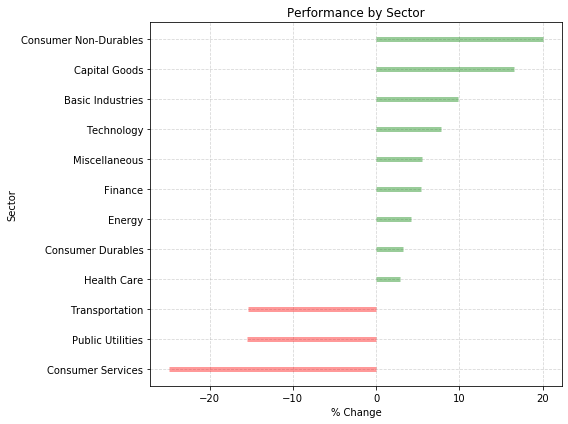

In [313]:
create_diverging_bars(stocks_dif,"sector")

In [314]:
def create_group_performance_table(df,parameter,best_or_worst,number):
    values_name = parameter+"_weighted_%_change"
    parameter_name = parameter.capitalize()
    df_copy = df.copy()
    group = df_copy.loc[:,[parameter,values_name]].groupby(parameter).sum()
    if best_or_worst == "best":
        group.sort_values(by=values_name,inplace=True,ascending=False)
    else:
        group.sort_values(by=values_name,inplace=True)
    return group.head(number)

In [315]:
create_group_performance_table(stocks_dif,"industry","best",5)

,industry_weighted_%_change
industry,
Precision Instruments,92.670000
Shoe Manufacturing,61.861036
Tobacco,61.354996
Ordnance And Accessories,59.984215
Paper,51.067167


In [316]:
create_group_performance_table(stocks_dif,"industry","worst",5)

,industry_weighted_%_change
industry,
Catalog/Specialty Distribution,-91.413910
Electronics Distribution,-81.640000
Consumer Electronics/Video Chains,-80.487327
Tools/Hardware,-80.200000
Aluminum,-70.171281


In [333]:
def create_pie_chart(df,parameter):
    values_name = "mc_"+parameter+"_weight_overall"
    parameter_name = parameter.capitalize()
    df_copy = df.copy()
    group = df_copy.loc[:,[parameter,values_name]].groupby(parameter).sum()
    group.plot(kind='pie', subplots=True, figsize=(8, 8),legend=False,autopct='%1.1f%%')
    plt.title(parameter_name+"s Comprising US Stock Market by Market Cap.")
    plt.ylabel("")
    plt.show()

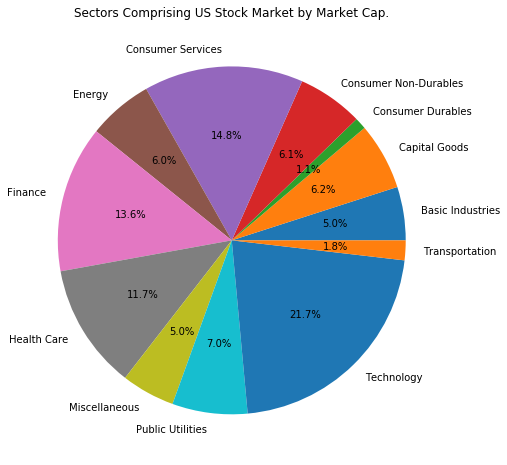

In [334]:
create_pie_chart(stocks_dif,"sector")

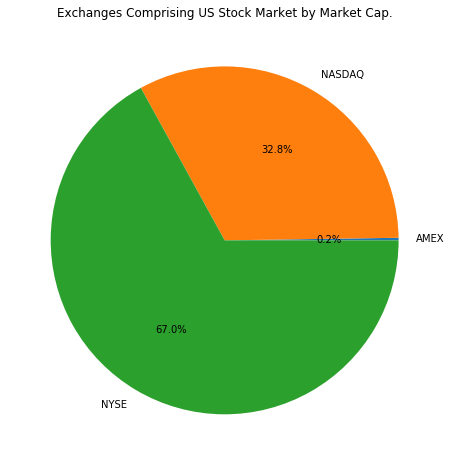

In [335]:
create_pie_chart(stocks_dif,"exchange")